#Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/tiny-faces-pytorch

/content/drive/MyDrive/tiny-faces-pytorch


#Installing Dependencies
##Note : Restart Runtime after installing


In [ ]:
!pip3 install treelib
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for treelib: filename=treelib-1.6.1-py3-none-any.whl size=18385 sha256=f78762012e01e73585958885a980e844e4b91a592d1a4ca487d2faafbc39c9b9
  Stored in directory: /root/.cache/pip/wheels/89/be/94/2c6d949ce599d1443426d83ba4dc93cd35c0f4638260930a53
Successfully built treelib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750 kB 14.5 MB/s 
     |████████████████████████████████| 172 kB 72.1 MB/s 
     |████████████████████████████████| 17.3 MB 63.1 MB/s 
     |████████████████████████████████| 91 kB 11.8 MB/s 
     |████████████████████████████████| 57 kB 5.4 MB/s 
     |████████████████████████████████| 2.1 MB 49.9 MB/s 
     |████████████████████████████████| 247 kB 73.0 MB/s 
     |████████████████████████████████| 1.2 MB 59.2 MB/s 
     |████████████████████████████████| 2.0 MB 51.8 MB

#Defining Variables

In [ ]:
data_dir='data/WIDER'
pre_trained_model='weights'
traindata='data/WIDER/wider_face_split/wider_face_train_bbx_gt.txt'
checkpoints='/content/tiny-faces-pytorch/weights/checkpoint_50_best.pth'
checkpoints='weights/checkpoint_50_best.pth'
pred_dir='predictions'
lr=1e-4
momentum=0.9
resume = True
weight_decay=0.0005
start_epoch=0
save_every=10
epochs=200

#Importing Libraries

In [ ]:
import os
from torch import nn
from torchvision.models import resnet50, resnet101

import os.path as osp
import argparse
import torch
from torch import optim
from torchvision import transforms

import trainer
from datasets import get_dataloader
from models.loss import DetectionCriterion
import json
import numpy as np
import torch
from PIL import Image
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm
from imageio import imread
from matplotlib import pyplot as plt

import trainer
from datasets import get_dataloader
from datasets.wider_face import WIDERFace
from models.model import DetectionModel
from utils import visualize

#Defining Model

In [ ]:
class DetectionModel(nn.Module):
    """
    Hybrid Model from Tiny Faces paper
    """

    def __init__(self, base_model=resnet101, num_templates=1, num_objects=1):
        super().__init__()
        # 4 is for the bounding box offsets
        output = (num_objects + 4)*num_templates
        self.model = base_model(pretrained=True)

        # delete unneeded layer
        del self.model.layer4

        self.score_res3 = nn.Conv2d(in_channels=512, out_channels=output,
                                    kernel_size=1, padding=0)
        self.score_res4 = nn.Conv2d(in_channels=1024, out_channels=output,
                                    kernel_size=1, padding=0)

        self.score4_upsample = nn.ConvTranspose2d(in_channels=output, out_channels=output,
                                                  kernel_size=4, stride=2, padding=1, bias=False)
        self._init_bilinear()

    def _init_weights(self):
        pass

    def _init_bilinear(self):
        """
        Initialize the ConvTranspose2d layer with a bilinear interpolation mapping
        :return:
        """
        k = self.score4_upsample.kernel_size[0]
        factor = np.floor((k+1)/2)
        if k % 2 == 1:
            center = factor
        else:
            center = factor + 0.5
        C = np.arange(1, 5)

        f = np.zeros((self.score4_upsample.in_channels,
                      self.score4_upsample.out_channels, k, k))

        for i in range(self.score4_upsample.out_channels):
            f[i, i, :, :] = (np.ones((1, k)) - (np.abs(C-center)/factor)).T @ \
                            (np.ones((1, k)) - (np.abs(C-center)/factor))

        self.score4_upsample.weight = torch.nn.Parameter(data=torch.Tensor(f))

    def learnable_parameters(self, lr):
        parameters = [
            # Be T'Challa. Don't freeze.
            {'params': self.model.parameters(), 'lr': lr},
            {'params': self.score_res3.parameters(), 'lr': 0.1*lr},
            {'params': self.score_res4.parameters(), 'lr': 1*lr},
            {'params': self.score4_upsample.parameters(), 'lr': 0}  # freeze UpConv layer
        ]
        return parameters

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        # res2 = x

        x = self.model.layer2(x)
        res3 = x

        x = self.model.layer3(x)
        res4 = x

        score_res3 = self.score_res3(res3)

        score_res4 = self.score_res4(res4)
        score4 = self.score4_upsample(score_res4)

        # We need to do some fancy cropping to accomodate the difference in image sizes in eval
        if not self.training:
            # from vl_feats DagNN Crop
            cropv = score4.size(2) - score_res3.size(2)
            cropu = score4.size(3) - score_res3.size(3)
            # if the crop is 0 (both the input sizes are the same)
            # we do some arithmetic to allow python to index correctly
            if cropv == 0:
                cropv = -score4.size(2)
            if cropu == 0:
                cropu = -score4.size(3)

            score4 = score4[:, :, 0:-cropv, 0:-cropu]
        else:
            # match the dimensions arbitrarily
            score4 = score4[:, :, 0:score_res3.size(2), 0:score_res3.size(3)]

        score = score_res3 + score4

        return score


#Downloading Wider Faces Dataset

In [ ]:
if os.path.exists(data_dir) is False:
  print("Downloading Dataset")
  os.makedirs(data_dir, exist_ok=True)
  !wget https://huggingface.co/datasets/wider_face/resolve/main/data/WIDER_train.zip -O data/WIDER/WIDER_train.zip
  !wget https://huggingface.co/datasets/wider_face/resolve/main/data/WIDER_val.zip -O data/WIDER/WIDER_val.zip
  !wget https://huggingface.co/datasets/wider_face/resolve/main/data/WIDER_test.zip -O data/WIDER/WIDER_test.zip
  !wget http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip -O data/WIDER/wider_face_split.zip
  !unzip data/WIDER/WIDER_train.zip -d data/WIDER
  !unzip data/WIDER/WIDER_test.zip -d data/WIDER
  !unzip data/WIDER/WIDER_val.zip -d data/WIDER
  !unzip data/WIDER/wider_face_split.zip -d data/WIDER
else:
  print('dataset already present')

dataset already present


#Downloading Pretrained Model

In [ ]:
if os.path.exists(pred_dir) is False:
  os.makedirs(pred_dir, exist_ok=True)

if os.path.exists(pre_trained_model) is False:
  print("Downloading pretrained Model")
  os.makedirs(pre_trained_model, exist_ok=True)
  %cd weights
  !gdown https://drive.google.com/u/0/uc?id=1V8c8xkMrQaCnd3MVChvJ2Ge-DUfXPHNu&export=download
  %cd ..
else:
  print('PreTrained Model already Present')

PreTrained Model already Present


#Training Script

In [ ]:
def main():
    # args = arguments()

    num_templates = 25  # aka the number of clusters

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    img_transforms = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    train_loader, _ = get_dataloader(traindata, num_templates,
                                     img_transforms=img_transforms)

    model = DetectionModel(num_objects=1, num_templates=num_templates)
    loss_fn = DetectionCriterion(num_templates)

    # directory where we'll store model weights
    weights_dir = "weights"
    if not osp.exists(weights_dir):
        os.mkdir(weights_dir)

    # check for CUDA
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    optimizer = optim.SGD(model.learnable_parameters(lr), lr=lr,
                          momentum=momentum, weight_decay=weight_decay)
    # optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    if resume:
        checkpoint = torch.load(checkpoints,map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        # Set the start epoch if it has not been
        # if not start_epoch:
        #   start_epoch = checkpoint['epoch']

    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=20,
                                          last_epoch=start_epoch-1)

    # train and evalute for `epochs`
    for epoch in range(start_epoch, epochs):
        trainer.train(model, loss_fn, optimizer, train_loader, epoch, device=device)
        scheduler.step()

        if (epoch+1) % save_every == 0:
            trainer.save_checkpoint({
                'epoch': epoch + 1,
                'batch_size': 
                
                
                
                
                
                train_loader.batch_size,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }, filename="checkpoint_{0}.pth".format(epoch+1), save_path=weights_dir)


if __name__ == '__main__':
    main()


#Inference on Test Data
##Results stored to Predictions folder

Dataset loaded
4 samples in the test dataset


  0%|                                                                                              | 0/4 [00:00<?, ?it/s]

Number of GT bboxes 149


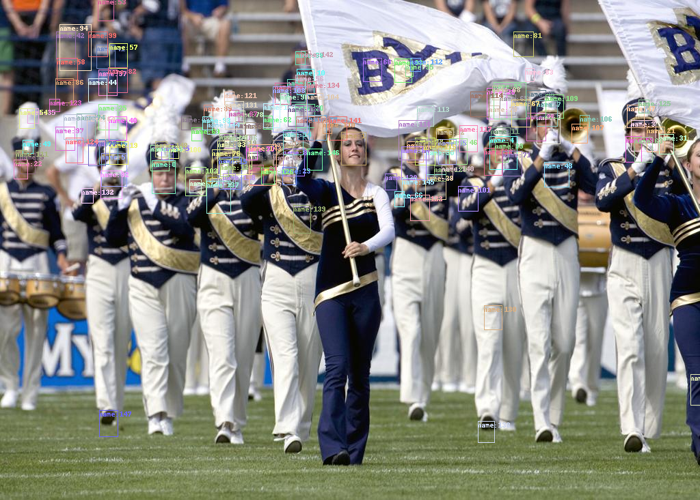

 25%|█████████████████████▌                                                                | 1/4 [00:17<00:53, 17.88s/it]

Number of GT bboxes 2


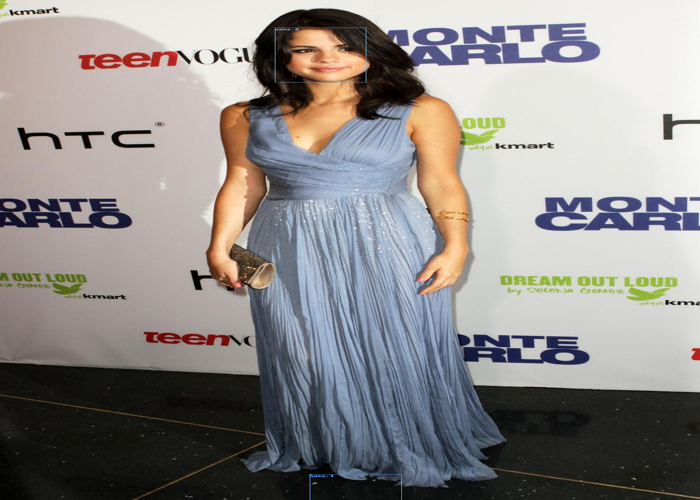

 50%|███████████████████████████████████████████                                           | 2/4 [01:10<01:17, 38.55s/it]

Number of GT bboxes 17


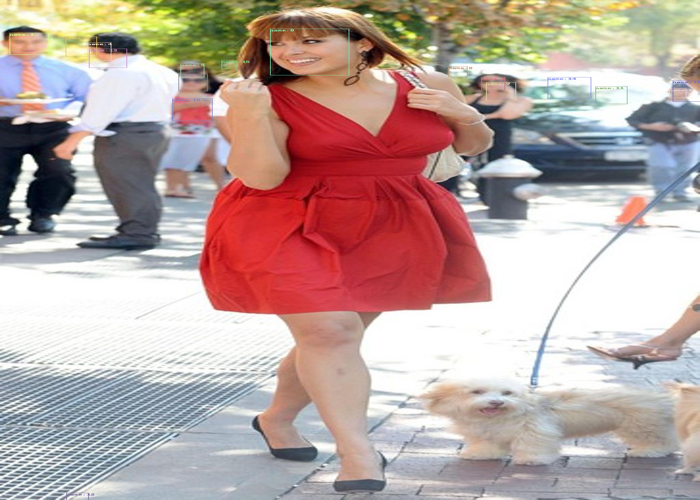

 75%|████████████████████████████████████████████████████████████████▌                     | 3/4 [02:02<00:44, 44.41s/it]

Number of GT bboxes 1


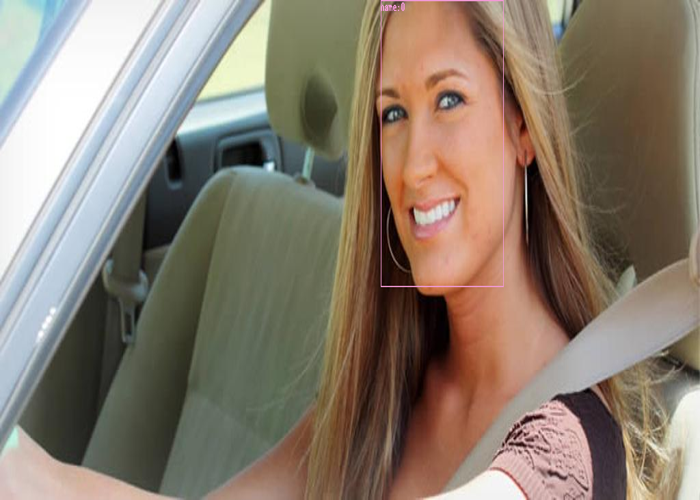

100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:13<00:00, 33.36s/it]


In [ ]:
def dataloader(dataset):

    val_transforms = transforms.ToTensor()

    val_loader, templates = get_dataloader(dataset,
                                           train=False, split='test',
                                           img_transforms=val_transforms)
    return val_loader, templates


def get_model(checkpoint, num_templates=25):
    model = DetectionModel(num_templates=num_templates)
    if torch.cuda.is_available():

      checkpoint = torch.load(checkpoint)
    else :
      checkpoint = torch.load(checkpoint,map_location='cpu')
    model.load_state_dict(checkpoint["model"])
    return model


def write_results(dets, img_path, split, results_dir=None):
    results_dir = results_dir or "{0}_results".format(split)

    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    filename = osp.join(results_dir, img_path.replace('jpg', 'txt'))
    file_dir = os.path.dirname(filename)
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    
    with open(filename, 'w') as f:
        f.write(img_path.split('/')[-1] + "\n")
        f.write(str(dets.shape[0]) + "\n")

        for x in dets:
            left, top = np.round(x[0]), np.round(x[1])
            width = np.round(x[2]-x[0]+1)
            height = np.round(x[3]-x[1]+1)
            score = x[4]
            d = "{0} {1} {2} {3} {4}\n".format(int(left), int(top),
                                               int(width), int(height), score)
            f.write(d)


def run(model, val_loader, templates, prob_thresh, nms_thresh, device, split,
        results_dir=None, debug=False):
    for idx, (img, filename) in tqdm(enumerate(val_loader), total=len(val_loader)):
        dets = trainer.get_detections(model, img, templates, val_loader.dataset.rf,
                                      val_loader.dataset.transforms, prob_thresh,
                                      nms_thresh, device=device)

        mean = torch.as_tensor([0.485, 0.456, 0.406], dtype=torch.float32, device=img.device)
        std = torch.as_tensor([0.229, 0.224, 0.225], dtype=torch.float32, device=img.device)
        img=(img[0]).permute((1, 2, 0))
        img=np.clip(img.numpy(),0,1)
        
        im = Image.fromarray((img*255).astype('uint8'), 'RGB')
        pred_image=visualize.visualize_bboxes(im, dets)
        pred_image=pred_image.resize((700,500))
        display(pred_image)
        
        pred_image=pred_image.save(f"{pred_dir}/{idx}.jpg")
        write_results(dets, filename[0], split, results_dir)


def main():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')

    val_loader, templates = dataloader(dataset)
    num_templates = templates.shape[0]
    
    checkpoint = checkpoints

    model = get_model(checkpoint, num_templates=num_templates)

    with torch.no_grad():
        # run model on val/test set and generate results files
        pred_image = run(model, val_loader, templates, prob_thresh=0.03, nms_thresh=0.3,
            device=device, split='test',
            results_dir=None, debug=False)    


if __name__ == "__main__":
    main()
